# Projet Python 2020 : Un GPS personnalisé pour les cyclistes

## Introduction : 

Petit teaser de notre super chouette sujet

## Les importations : 

In [53]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
import os
import time
import datetime

In [54]:
import pyroutelib3
from pyroutelib3 import Router
import requests, json
import urllib.parse
import tempfile
import zipfile

In [55]:
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [56]:
departements = gpd.read_file('https://www.data.gouv.fr/fr/datasets/r/ec305e78-f231-4a77-b32c-1e0c4c67615e')
dpt = departements[departements['code_departement'].isin(['75', '77', '78', '91', '92', '93', '94', '95' ])]

## I] Visualisation des données

### 1) Les pistes (Romane)

### 2) Les vélos en libre-service (Imane)

In [57]:
temporary_location = tempfile.gettempdir()
def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
  with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

download_unzip('https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12')

,insee,nom,wikipedia,surf_ha,geometry
0,97223,Saint-Esprit,fr:Saint-Esprit (Martinique),2318,"POLYGON ((-60.93595 14.58812, -60.93218 14.585..."
1,97233,Le Morne-Vert,fr:Le Morne-Vert,1325,"POLYGON ((-61.12165 14.71928, -61.11852 14.716..."
2,97208,Fonds-Saint-Denis,fr:Fonds-Saint-Denis,2374,"POLYGON ((-61.13355 14.74657, -61.13066 14.748..."
3,97224,Saint-Joseph,fr:Saint-Joseph (Martinique),4324,"POLYGON ((-61.08459 14.72510, -61.08430 14.722..."
4,97212,Gros-Morne,fr:Gros-Morne,4601,"POLYGON ((-61.08459 14.72510, -61.08061 14.725..."


#### Velib - disponibilité en temps réel

Données disponibles au lien suivant : 
https://smartregionidf.opendatasoft.com/explore/dataset/velib-disponibilite-en-temps-reel/export/?disjunctive.name&disjunctive.is_installed&disjunctive.is_renting&disjunctive.is_returning&disjunctive.nom_arrondissement_communes

In [223]:
velib = gpd.read_file("https://smartregionidf.opendatasoft.com/explore/dataset/velib-disponibilite-en-temps-reel/download/?format=geojson&timezone=Europe/Berlin&lang=fr")

#### Cristolib et Vélo2 en libre-service à Créteil

Données disponibles aux liens suivants : 
- https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/information/


In [224]:
velos2 = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

#### Veligo

Données disponibles au lien suivant : https://smartregionidf.opendatasoft.com/explore/dataset/points-de-contact-veligo-location/information/

In [225]:
veligo = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/points-de-contact-veligo-location/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

#### Fusion des bases de données Vélib, Veligo et Velos2

In [226]:
#Ajout d'une colonne correspondant au type du vélo (vélib, véligo ou vélos2)

velib["type"]=["velib" for i in range(velib.shape[0])]
veligo["type"]=["veligo" for i in range(veligo.shape[0])]
velos2["type"]=["velos2" for i in range(velos2.shape[0])]

In [227]:
# Ajout d'une colonne disponibilité vélos pour ceux qui n'en ont pas

veligo["numbikesavailable"]=["N" for i in range(veligo.shape[0])]

#velib["numbikesavailable"][1:velib.shape[0]]=[0 for i in range(1, velib.shape[0])]

#velos2["available_bikes"]=[0 for i in range(velos2.shape[0])]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [229]:
# Selectionner et renommer les colonnes de chaque base

velib = velib[["name","geometry","type", "numbikesavailable"]]

veligo = veligo [["nom","geometry","type","numbikesavailable"]]
veligo.columns = ['name','geometry',"type","numbikesavailable"]

velos2 = velos2 [["name", "geometry","type","available_bikes"]]
velos2.columns = ['name','geometry',"type","numbikesavailable"]

In [230]:
velos = pd.concat([veligo, velib, velos2], ignore_index=True)

In [231]:
velos.shape

(2530, 4)

In [151]:
velos.shape[0] ==  veligo.shape[0] + velib.shape[0] + velos2.shape[0] 

True

In [189]:
velos

,name,geometry,type,numbikesavailable
0,ST MAUR DES FOSSES PDC,POINT (2.49129 48.80253),veligo,N
1,BRY PPDC1,POINT (2.52455 48.82955),veligo,N
2,CRETEIL PPDC1,POINT (2.45490 48.77790),veligo,N
3,FONTENAY SOUS BOIS PDC1,POINT (2.47531 48.84936),veligo,N
4,IVRY PDC1,POINT (2.40150 48.80670),veligo,N
...,...,...,...,...
2525,09 - EUROPARC,POINT (2.47131 48.76604),velos2,0
2526,50011 - CER11 - PLACE DE L'HOTEL DE VILLE (CB),POINT (2.03611 49.05160),velos2,0
2527,50020 - CONSEIL GÉNÉRAL,POINT (2.07435 49.03211),velos2,0
2528,50012 - CER12 - PLACE DU HAUT-GENCY,POINT (2.04512 49.04659),velos2,0


In [71]:
departements = gpd.read_file('https://www.data.gouv.fr/fr/datasets/r/ec305e78-f231-4a77-b32c-1e0c4c67615e')
dpt = departements[departements['code_departement'].isin(['75', '77', '78', '91', '92', '93', '94', '95' ])]

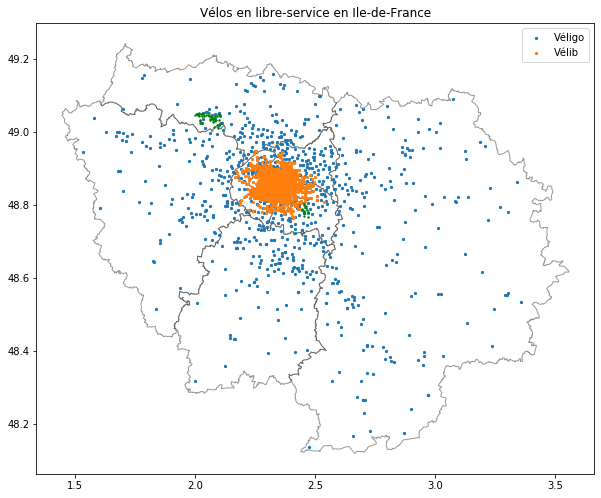

In [72]:
fig, ax = plt.subplots(figsize = (10,10))
dpt.plot(ax=ax, color = 'white', edgecolor = 'black', alpha = 0.4)

velos[velos["type"]=="veligo"].plot(ax=ax, color='tab:blue', label = 'Véligo', markersize=5)
velos[velos["type"]=="velib"].plot(ax=ax, color='tab:orange', label = 'Vélib', markersize=5)
velos[velos["type"]=="velos2"].plot(ax=ax, color='green', markersize=2)

plt.title('Vélos en libre-service en Ile-de-France')
plt.legend()
plt.show()

In [124]:
centre = [48.8534 , 2.3488] #Centre de paris 
idf = folium.Map(location = centre, zoom_start = 13)
idf

### 3) Les accidents (Vinciane)

In [ ]:
accident_velo = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/3d5f2317-5afd-4a9f-a9c5-bd4fe0113f39')
accident_velo_idf = accident_velo[accident_velo['departement'].isin(['75','77','78','91','92','93','94','95'])]
accident_velo_idf = accident_velo_idf[['identifiant accident','lat','lon','gravite accident']]
accident_velo_idf.head(10)

In [ ]:
#On transforme les coordonnées latitudes/longitudes en coordonnées lisibles par géopandas
gdf = gpd.GeoDataFrame(accident_velo_idf, geometry=gpd.points_from_xy(accident_velo_idf.lon, accident_velo_idf.lat))
gdf = gdf.cx[1.44:3.57,48.12:49.2] #Nombreuses coordonnées manquantes, et quelques valeurs aberrantes éliminées
gdf  
#Au total, il nous reste 3400 données sur les 18 000  

In [ ]:
#Des clusters sont faits automatiquement par secteur ou les points sont proches
Paris = [48.85, 2.34]
map_accident = folium.Map(location = Paris , zoom_start=12)
marker_cluster = MarkerCluster().add_to(map_accident)

lat = gdf.lat
lng = gdf.lon
for lat, lng in zip(lat, lng):
    folium.Marker(location=[lat,lng],
    icon = folium.Icon(color='red', icon_color='black', icon='bicycle', prefix='fa'),
    ).add_to(marker_cluster)
    
map_accident

#### Analyses sur la gravité des accidents

In [ ]:
indemne = gdf[gdf['gravite accident']  == '0 - Indemne'][['lat', 'lon']]
blesse_leg = gdf[gdf['gravite accident']  == '1 - Blessé léger'][['lat', 'lon']]
blesse_hosp = gdf[gdf['gravite accident']  == '2 - Blessé hospitalisé'][['lat', 'lon']]
tue =gdf[gdf['gravite accident']  == '3 - Tué'][['lat', 'lon']]

In [ ]:
# Carte différenciant la gravité des accidents
Paris = [48.85, 2.34]
map_accident = folium.Map(location = Paris , zoom_start=10)

lat = indemne.lat
lng = indemne.lon
for lat, lng in zip(lat, lng):
        folium.Marker(location=[lat,lng],icon = folium.Icon(color='white', icon_color='black', icon='bicycle', prefix='fa')).add_to(map_accident)
lat = blesse_leg.lat
lng = blesse_leg.lon
for lat, lng in zip(lat, lng):
        folium.Marker(location=[lat,lng],icon = folium.Icon(color='beige', icon_color='black', icon='bicycle', prefix='fa')).add_to(map_accident)
lat = blesse_hosp.lat
lng = blesse_hosp.lon
for lat, lng in zip(lat, lng):
        folium.Marker(location=[lat,lng],icon = folium.Icon(color='lightred', icon_color='black', icon='bicycle', prefix='fa')).add_to(map_accident)
lat = tue.lat
lng = tue.lon
for lat, lng in zip(lat, lng):
        folium.Marker(location=[lat,lng],icon = folium.Icon(color='red', icon_color='black', icon='bicycle', prefix='fa')).add_to(map_accident)

map_accident

## II] Personnalisation du GPS

### 1) Un GPS qui prend en compte les accidents (Vinciane)

#### Les clusters d'accident avec la méthode DBSCAN

On utilise DBSCAN, qui permet de créer un cluster avec : 
- epsilon : la distance entre deux accidents liés au même lieu accidentogène. Nous avons choisi comme distance 50m.
- min_samples : le nombre de point minimum pour créer un cluster. Nous avons choisi 3 points, car 2 accidents au même endroit pourraient n'être dûs qu'à une coïncidence.

In [ ]:
X=gdf.loc[:,['lat','lon']]
kms_per_radian = 6371 
epsilon = 0.05/kms_per_radian

In [ ]:
#centre cluster
def get_centroid(cluster): 
    cluster_ary = np.asarray(cluster) 
    centroid = cluster_ary.mean(axis=0) 
    return centroid 

In [ ]:
dbsc = (DBSCAN(eps=epsilon, min_samples=3).fit(X)) 

X_labels = dbsc.labels_ 
num_clusters = len(set(dbsc.labels_)) 
print("Le nombre de clusters est de", num_clusters)
dbsc_clusters = pd.Series([X[X_labels==n] for n in range(num_clusters)]) 
cluster_centroids = dbsc_clusters.map(get_centroid) 

gdf['Xc_labelse'] = X_labels
gdf_filtered = gdf[X_labels>-1]


cent_lat, cent_lon = zip(*cluster_centroids)
centroids_df = pd.DataFrame({'lon':cent_lon, 'lat':cent_lat}) 
print("Le nombre d'accidents qui rentrent dans les clusters est de ", len(gdf_filtered))

In [ ]:
fig, ax = plt.subplots(figsize=[11, 8]) 
dpt.plot(ax=ax, color='0.9', edgecolor='black')

accident_scatter = ax.scatter(gdf['lon'], gdf['lat'], c ='midnightblue',alpha=0.25, s=50) 
centroid_scatter = ax.scatter(centroids_df['lon'], centroids_df['lat'],marker='x', linewidths=2, c='gold', s=50) 

ax.set_title("Clusters d'accidents et le centre des lieux accidentés", fontsize =20) 
ax.set_xlabel('Longitude', fontsize=12) 
ax.set_ylabel('Latitude', fontsize =12) 
ax.legend([accident_scatter, centroid_scatter], ['Accident', "Centre d'un cluster d'accident"], loc='upper right', fontsize = 12) 
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[8, 6]) 
dpt.plot(ax=ax, color='0.9', edgecolor='black')
filtres_scatter = ax.scatter(gdf_filtered['lon'], gdf_filtered['lat'],  c= 'red', alpha =0.25, s=50) 
centroid_scatter = ax.scatter(centroids_df['lon'], centroids_df['lat'],marker='x', linewidths=2, c='k', s=50) 
ax.set_title("Clusters d'accidents et le centre des lieux accidentés, sans les bruits", fontsize = 20) 
ax.set_xlabel('Longitude', fontsize = 16) 
ax.set_ylabel('Latitude', fontsize = 16) 
axes = plt.gca()
axes.set_xlim(2.00, 2.70)
axes.set_ylim(48.4, 49.1)
ax.legend([accident_scatter, centroid_scatter], ["Accident au sein d'un cluster", "Centre d'un cluster d'accident"], loc='upper right', fontsize = 12)
plt.show()

In [ ]:
centroids_df = centroids_df.dropna() #On trouve 1 valeur manquante, on l'enlève
centroids_df #Liste des lieux particulièrement accidentogènes en Ile-de-France

### 2) Un GPS qui informe sur les conditions météréologiques (Vinciane)

#### La météo en temps réel

In [ ]:
##On cherche l'heure et la date de la requête par le cycliste: 
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()) #Date et heure
Date = time.strftime('%Y-%m-%d', time.localtime()) #Date
Time = time.strftime('%H:%M', time.localtime()) #Heure
DateTime = time.strftime('%Y-%m-%dT%H:%M:%S', time.localtime()) 
print('Voic la date de la recherche : ', Date)
print("Voici l'heure de la recherche :", Time)
print(DateTime, 'heure')

In [ ]:
meteo_gpd = 'https://www.data.gouv.fr/fr/datasets/r/8e834f69-0b43-439a-87bd-87ca80c84cd7'
meteo_idf = gpd.read_file(meteo_gpd) 
#Base de donnée avec prévisions pour les 36h après sa mise à jour 

In [ ]:
meteo_idf = meteo_idf[['timestamp', 'forecast', '2_metre_temperature', 'total_water_precipitation',  'geometry']]
meteo_idf.head(10)

D'après la documentation, 

- La colonne "total_water_precipitation" correspond au cumul (depuis le début de la simulation) de la somme des flux au sol des précipitations liquides et solides (eau, neige, grêlons) en kg/m-2
- La colonne "2_metre_temperature" est la température diagnostiquée à 2m de hauteur au dessus du relief

In [ ]:
meteo_idf["duration"] = pd.to_datetime(meteo_idf["forecast"]) - pd.to_datetime(meteo_idf["timestamp"])
meteo_idf["duration"] = meteo_idf["duration"].astype("timedelta64[m]")
#Différence en minutes entre la prévision et l'heure prévue
meteo_idf = meteo_idf.cx[2.35,48.85] 
#On ne garde que les prévisions pour le centre de Paris ce qu'on suppose représentatif de la météo pour toute l'Ile-de-France
meteo_idf = meteo_idf.sort_values('forecast')

In [ ]:
meteo_idf2 = meteo_idf.reset_index()

In [ ]:
for i in range(1,len(meteo_idf2)):
    meteo_idf2.loc[i, 'diff_precipitation'] = meteo_idf2.loc[i,'total_water_precipitation']-meteo_idf2.loc[i-1,'total_water_precipitation']
#Parfois des erreurs dans la conception des données, lorsque "duree" est négative (impossible car signifierait que la somme des précipitations diminue dans le temps)
#Pour négliger ces erreurs, on remplace les valeurs négatives par 0
meteo_idf2.loc[(meteo_idf2["diff_precipitation"]<0), "diff_precipitation"] = 0

In [ ]:
meteo_idf2.head(8)

In [ ]:
for i in range(1,len(meteo_idf2)):
    meteo_idf2.loc[i, 'duree_intervalle'] = meteo_idf2.loc[i,'duration']-meteo_idf2.loc[i-1,'duration']

Conversion des données de précipitations en kg/m-2 en données mesurées en mm/h :
On a 1L/m² =1mm, et 1kg d'eau = 1L d'eau, d'où : 
- précipitation en 1h = (précipitations pendant l'intervalle)/(duree intervalle)*60 

La manière de mesurer les précipitations la plus répandue est la pluviométrie, qui correspond à la hauteur d'eau recueillie sur une surface plane (exprimée en mm). 
On sépare l'intensité de la pluie : 
- pluie très faible et négligeable  (de 0 à 2 mm/h)
- modérée et forte (plus 2 mm/h)

In [ ]:
meteo_idf2["precipitations mm/h"] = ((meteo_idf2["diff_precipitation"])/(meteo_idf2["duree_intervalle"]))*60
##A vérifier
meteo_idf3 = meteo_idf2[['forecast', '2_metre_temperature','precipitations mm/h']]
meteo_idf3.sort_values('forecast').head(5)

In [ ]:
meteo_idf_temps_reel = meteo_idf2.loc[meteo_idf2['forecast'] <= DateTime][['forecast', '2_metre_temperature', 'precipitations mm/h' ]].sort_values('forecast').tail(1)
# On fait en rognant l'heure et non en approximant => voir si améliorable ou pas
meteo_idf_temps_reel

In [ ]:
if meteo_idf_temps_reel['precipitations mm/h'].item()> 2.000 and (meteo_idf_temps_reel['2_metre_temperature'].item() > -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) < 1:
    print('Attention il pleut et il y a peut-être du verglas sur la chaussée.')
elif meteo_idf_temps_reel['precipitations mm/h'].item() > 2.000 and (meteo_idf_temps_reel['2_metre_temperature'].item() < -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) > 1:
    print("Attention il pleut, mais normalement, il n'y a pas de verglas sur la chaussée")
elif meteo_idf_temps_reel['precipitations mm/h'].item() < 2.00 and (meteo_idf_temps_reel['2_metre_temperature'].item() > -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) < 1:
    print("Il ne pleut pas, mais attention, il peut y avoir du verglas.")
else:
    print("Quel chanceux, il n'y a ni pluie ni verglas.")
print('Pendant votre trajet il fera une température de',round(meteo_idf_temps_reel['2_metre_temperature'].item(),2), 'degrès.')

#### Les heures de lever et de coucher du soleil : 

Base de donnée à télécharger par année sur le site : http://ptaff.ca/
Elle est sur Github

In [ ]:
heures_soleil = pd.read_csv('D:/Données/ENSAE/lever_coucher_soleil.csv',  sep = ',')
heures_soleil.loc[heures_soleil['Date'] == Date] 

In [ ]:
heures_soleil.loc[heures_soleil['Date'] == Date]
if  Time >=heures_soleil.loc[heures_soleil['Date'] == Date]['Lever_du_soleil'].any() and Time <=heures_soleil.loc[heures_soleil['Date'] == Date]['Coucher_du_soleil'].any():
    print('Il est', Time,', vous roulez de jour.')
else: 
    print('Il est', Time, "heure",'attention, vous roulez de nuit.')

### 3)  Un GPS qui prend en compte les affluences (Romane)

## III] Utilisation du GPS (Imane)

#### Choix du point de départ et du point d'arrivée

In [182]:
adresse_depart =input("D'où partez-vous ? (numéro, rue, code postal ville)")

adresse_arrivee = input("Où voulez-vous aller ? (numéro, rue, code postal ville)")

D'où partez-vous ? (numéro, rue, code postal ville) 5, Avenue Anatole France, 75007 Paris
Où voulez-vous aller ? (numéro, rue, code postal ville) 1, Rue de Rivoli, 75001 Paris


In [161]:
print(adresse_depart)

25, route nationale 20, 91180


In [162]:
print(adresse_arrivee)

25, avenue de la division Leclerc, 91290


In [183]:
#adresse_depart = "5, Avenue Anatole France, 75007 Paris"
#adresse_arrivee = "1, Rue de Rivoli, 75001 Paris"
dep_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_depart) + "&format=json").json()
arr_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_arrivee) + "&format=json").json()
coord_dep = list(dep_json['features'][0].get('geometry').get('coordinates'))
coord_arr = list(arr_json['features'][0].get('geometry').get('coordinates'))

In [184]:
x = input("Avez-vous votre propre vélo ? Entrez 'oui' ou 'non' ")

Avez-vous votre propre vélo ? Entrez 'oui' ou 'non'  non


## Lorsque l'utilisateur n'a pas son propre vélo

In [232]:
if(x=='non'):
    
    # Ré-initialisation de la carte 
    centre = coor_depart 
    idf = folium.Map(location = centre, zoom_start = 13)
    
    # Calcul de la distance en km entre le point de départ et toutes les stations

    distances = []
    for i in range(len(velos.geometry)):
      a = (max(velos.geometry[i].x, coord_dep[0]) - min(velos.geometry[i].x, coord_dep[0]))**2 + (max(velos.geometry[i].y, coord_dep[1]) - min(velos.geometry[i].y, coord_dep[1]))**2
      a = a**(1/2)*100
      distances.append(a)
    
    #Station la plus proche du point de départ 

    i = distances.index(min(distances))

    station_dep = [velos["geometry"][i].y, velos["geometry"][i].x]

    print( 'Station la plus proche du point de départ :', velos["name"][i] )
    
    
    # Vérification disponibilité vélo dans la station de départ
    
    if(velos["numbikesavailable"][i]!="0" and velos["numbikesavailable"][i]!="N" ):
        print("\n \n Un vélo est disponible à la station la plus proche du point de départ")
        
    elif(velos["numbikesavailable"][i]=="N"):
        print("\n \n Nous ne disposons pas d'information concernant la disponibilité d'un vélo à la station la plus proche du point de départ")
        
    elif(velos["numbikesavailable"][i]=="0"):
        print("\n \n Pas de vélo disponible à la station la plus proche du point de départ")

        k = i
        
        while( velos["numbikesavailable"][k]=="0"):
            
            # Nouvelle station la plus proche et avec vélo disponible

            distances.pop(i)
            k = distances.index(min(distances))

            station_dep = [velos["geometry"][k].y, velos["geometry"][k].x]

        print( 'Station la plus proche du point de départ avec vélo disponible : \n', velos["name"][k] )
          
    
    print('\n \nDistance à effectuer à pied (point de départ -> station de départ) :', round(min(distances),2), "km")
    print("soit un temps de trajet d'environ :", round(min(distances)*1000/66.67), "minutes\n \n")
    
    t = min(distances)*1000/66.67
    
    # Calcul de la distance en km entre le point d'arrivée et toutes les stations

    distances = []
    for i in range(len(velos.geometry)):
      a = (max(velos.geometry[i].x, coord_arr[0]) - min(velos.geometry[i].x, coord_arr[0]))**2 + (max(velos.geometry[i].y, coord_arr[1]) - min(velos.geometry[i].y, coord_arr[1]))**2
      a = a**(1/2)*100
      distances.append(a)
    
    #Station la plus proche du point d'arrivée

    j = distances.index(min(distances))

    station_arr = [velos["geometry"][j].y, velos["geometry"][j].x] 
    
          
    # Durée et distance trajet à vélo
    
    d = (max(station_dep[0], station_arr[0]) - min(station_dep[0], station_arr[0]))**2 + (max(station_dep[1], station_arr[1]) - min(station_dep[1], station_arr[1]))**2
    d = d**(1/2)*100                                                    
                                                                                  

    print( 'Station la plus proche du point d arrivée : ', velos["name"][j] )
    print( '\n \nDistance à effectuer en vélo (station de départ -> station d\'arrivée) :', round(d,2), "km")
    print("soit un temps de trajet d'environ :", round(d*1000/250), "minutes\n")
    print( '\n Distance à effectuer à pied (station d\'arrivée -> point d\'arrivée) :', round(min(distances),2), "km")
    print("soit un temps de trajet d'environ :", round(min(distances)*1000/66.67), "minutes\n \n")
    
    print("Le temps total du trajet est donc de :", round(t+d*1000/250+min(distances)*1000/66.67)  ,"minutes\n \n")
    
    # Si le temps total du trajet calculé > temps de trajet en faisant tout à pied, alors faire le trajet à pied 
    
    d_pied = (max(coord_dep[0], coord_arr[0]) - min(coord_dep[0], coord_arr[0]))**2 + (max(coord_dep[1], coord_arr[1]) - min(coord_dep[1], coord_arr[1]))**2
    d_pied = d_pied**(1/2)*100
    t_pied = d_pied*1000/66.67
    
    if( t+d*1000/250+min(distances)*1000/66.67 > t_pied ):
        
        print("ATTENTION : Il serait plus judicieux de faire tout le trajet à pied car :")
        print("Distance du point de départ au point d'arrivée :", round(d_pied,2), "km")
        print("Temps du trajet à pied :", round(t_pied), "minutes\n" )
            
    #Trajet à pied : point de départ -> station départ
                                                                                         
    coor_depart = [coord_dep[1], coord_dep[0]] 
    coor_arrivee = [coord_arr[1], coord_arr[0]] 

    folium.Marker(coor_depart,popup="Départ").add_to(idf)
    folium.Marker(coor_arrivee,popup="Arrivée").add_to(idf)
    
    router = pyroutelib3.Router("foot")

    depart = router.findNode(coor_depart[0], coor_depart[1])
    arrivee = router.findNode(station_dep[0], station_dep[1])

    routeLatLons=[coor_depart,station_dep]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="black", weight=2.5, opacity=1).add_to(idf)
    
    # Trajet en vélo : station départ -> station arrivée
    
    router = pyroutelib3.Router("cycle")
    depart = router.findNode(station_dep[0], station_dep[1])
    arrivee = router.findNode(station_arr[0], station_arr[1])

    routeLatLons=[station_dep,station_arr]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="red", weight=2.5, opacity=1).add_to(idf)
    
    
    # Trajet à pied : station arrivée -> point d'arrivée
    
    router = pyroutelib3.Router("foot")
    depart = router.findNode(station_arr[0], station_arr[1])
    arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])

    routeLatLons=[station_arr, coor_arrivee]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="black", weight=2.5, opacity=1).add_to(idf)
    

Station la plus proche du point de départ : Bourdonnais - Tour Eiffel

 
 Un vélo est disponible à la station la plus proche du point de départ

 
Distance à effectuer à pied (point de départ -> station de départ) : 0.23 km
soit un temps de trajet d'environ : 3 minutes
 

Station la plus proche du point d arrivée :  Saint-Honoré - Musée du Louvre

 
Distance à effectuer en vélo (station de départ -> station d'arrivée) : 3.94 km
soit un temps de trajet d'environ : 16 minutes


 Distance à effectuer à pied (station d'arrivée -> point d'arrivée) : 0.13 km
soit un temps de trajet d'environ : 2 minutes
 

Le temps total du trajet est donc de : 21 minutes
 



In [160]:
idf

# Lorsque l'utilisateur a son propre vélo

In [96]:
if(x=='oui'):
    
    # Ré-initialisation de la carte 
    centre = coor_depart 
    idf = folium.Map(location = centre, zoom_start = 13)
    
    coor_depart = [coord_dep[1], coord_dep[0]] 
    coor_arrivee = [coord_arr[1], coord_arr[0]] 

    folium.Marker(coor_depart,popup="Départ").add_to(idf)
    folium.Marker(coor_arrivee,popup="Arrivée").add_to(idf)
    
    # Trajet en vélo : point départ -> point d'arrivée
    
    router = pyroutelib3.Router("cycle")
    depart = router.findNode(coor_depart[0], coor_depart[1])
    #print(depart)
    arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])
    #print(arrivee)

    routeLatLons=[coor_depart,coor_arrivee]
    status, route = router.doRoute(depart, arrivee)
    if status == 'success':
      #print("Votre trajet existe")
      routeLatLons = list(map(router.nodeLatLon, route))
    else:
      print("Votre trajet n'existe pas")

    #print(routeLatLons)
    for coord in routeLatLons:
      coord=list(coord)
      folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

    folium.PolyLine(routeLatLons, color="red", weight=2.5, opacity=1).add_to(idf)
    

In [97]:
idf

#### Signalement de la part de l'utilisateur après le trajet

In [87]:
a=input("Suite à votre trajet, souhaitez-vous signaler quelque chose ? Entrez 'oui' ou 'non'")

if(a=='oui'):
    x=input("Que souhaitez-vous signaler ?")
    print("Cliquez à l'endroit correspondant sur la carte")
    
print("Merci de contribuer à l'amélioration notre application!")

idf.add_child(folium.ClickForMarker(popup=x))

#idf.add_child(folium.LatLngPopup())

Suite à votre trajet, souhaitez-vous signaler quelque chose ? Entrez 'oui' ou 'non' oui
Que souhaitez-vous signaler ? accident


Cliquez à l'endroit correspondant sur la carte
Merci de contribuer à l'amélioration notre application!
